**Problem 2:** Starting in Kaggle.
On October 22nd, we are opening a Kaggle competition made for this class.
In that one, you willbe participating on your own. This is an intro to get us started, and also an excuse to work with regularization and regression which we have been discussing.
1.  Let’s start with our first Kaggle submission in a playground regression competition.  Make an account to Kaggle and find https://www.kaggle.com/c/house-prices-advanced-regression-techniques/
2.  Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models.  Then run a ridge regression usingα= 0.1.
Make a submission of this prediction, what is the RMSE you get?(Hint:  remember to exponentiate np.expm1(ypred) your predictions).
3.  Compare a ridge regression and a lasso regression model.  Optimize the alphas using crossvalidation.  What is the best score you can get from a single ridge regression model and froma single lasso model?
4.  Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary thestrength of regularization parameter alpha.
5.  Add the outputs of your models as features and train a ridge regression on all the featuresplus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit.What score can you get?  
(We will be discussing ensembling more, later in the class, but youcan start playing with it now).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### 2.1: Getting Data and setting up Kaggle

In [4]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### 2.2 : Preprocessing the Data

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log1p
  from ipykernel import kernelapp as app


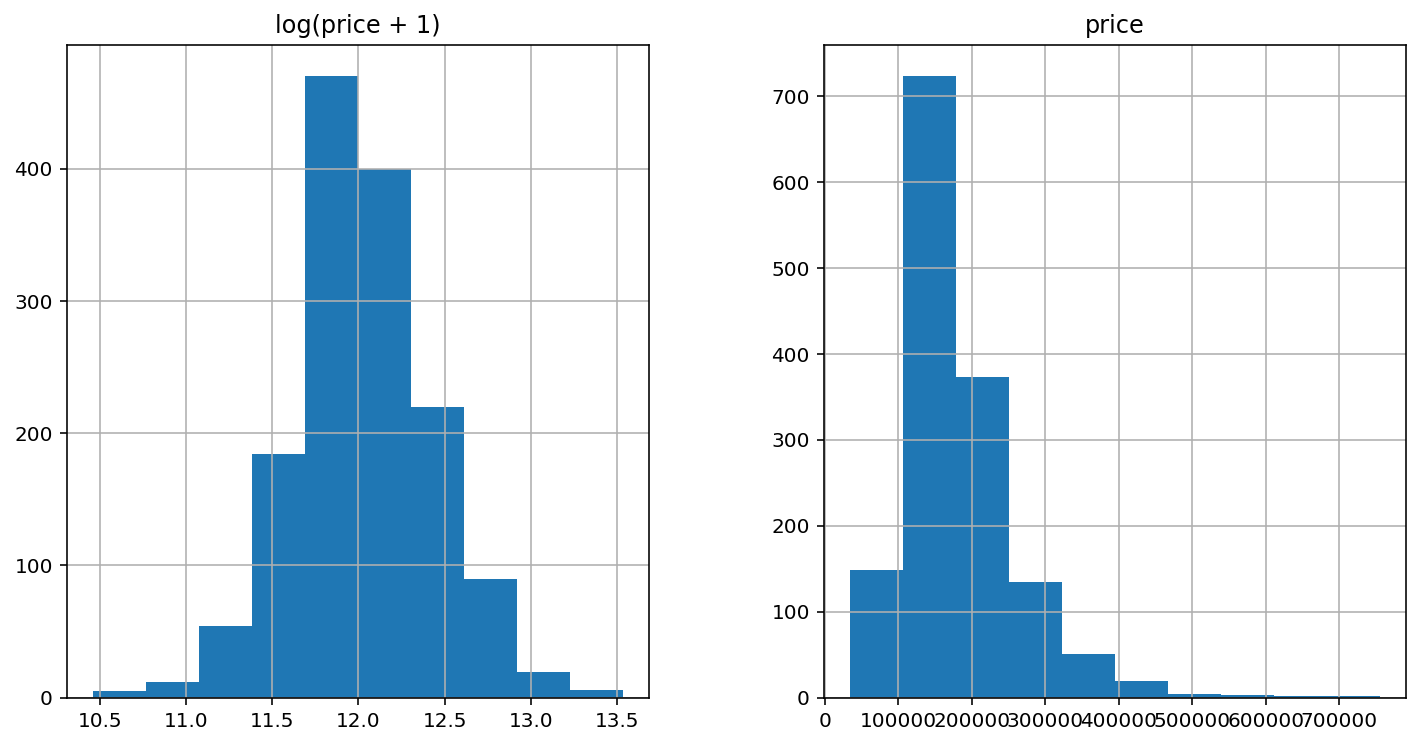

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.mean())

In [6]:
# Creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [7]:
# Cross validation RMSE function
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [8]:
ridgeModel = Ridge(alpha=0.1)

In [9]:
# Score for alpha=0.1 Ridge Regression - With cross validation among 5 bins
cv_ridge = rmse_cv(ridgeModel).mean()
print(cv_ridge)

0.13777538277187878


In [10]:
# Score for alpha=0.1 Ridge Regression - No cross validation
ridgeModel.fit(X_train,y)
pred=ridgeModel.predict(X_train)
rmse_ridge = np.sqrt(mean_squared_error(y,pred))
print(rmse_ridge)

0.09211955585640513


In [11]:
# Prediction on Test set using Ridge Model with alpha=0.1
pred = ridgeModel.predict(X_test)
np.expm1(pred)

array([121519.48656871, 159637.89835116, 187900.72801905, ...,
       176763.91404077, 121610.54954924, 219174.15546004])

### 2.3: Comparing Lasso and Ridge Regression

Ridge and Lasso regression done as single iteration and with cross-validations.

Observation: Lesser RMSE error in Lasso.

In [12]:
lassoModelCV = LassoCV(alphas = [5, 1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(lassoModelCV).mean()


/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: Fu

0.12314421090977432

In [34]:
ridgeModelCV = RidgeCV(alphas = [5, 1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(ridgeModelCV).mean()

0.1278217968244439

In [23]:
# For Submission to Kaggle
# Single Ridge Regression

ridgeModel = Ridge(alpha=.011)
ridgeModel.fit(X_train,y)
pred=ridgeModel.predict(X_train)

ids = test['Id']
yfinalpred = ridgeModel.predict(X_test)
sale_prices = np.expm1(yfinalpred)

result = pd.DataFrame({ 'Id': ids, 'SalePrice': np.round(sale_prices, 3) })
display(result.head())

result.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)

,Id,SalePrice
0,1461,121701.571
1,1462,164259.841
2,1463,188744.722
3,1464,201548.434
4,1465,198848.343


RMSE Score of 0.13029 on Kaggle.

In [32]:
# Single Lasso Regression
lassoModel = Lasso(alpha=.011)
lassoModel.fit(X_train,y)
pred=lassoModel.predict(X_train)
rmse_lasso = np.sqrt(mean_squared_error(y,pred))
print(rmse_lasso)

0.15429271584512616


In [33]:
yrpred=ridgeModel.predict(X_train)
r2_score_ridge = r2_score(y, yrpred)
print("Ridge - R^2 on test data : %f" % r2_score_ridge)

ylpred=lassoModel.predict(X_train)
r2_score_lasso = r2_score(y, ylpred)
print("Lasso - R^2 on test data : %f" % r2_score_lasso)


Ridge - R^2 on test data : 0.947125
Lasso - R^2 on test data : 0.850698


### 2.4: L0 Norm of Lasso Regression

L0 Norm is essentially the non-zero coefficients of a Lasso regression. Since Lasso nullifies or makes zero a few coefficients that are irrelevant l0 norm gives the number of coeeficients that are the most significant for the regression.

In [17]:
coef = pd.Series(lassoModel.coef_, index = X_train.columns)

In [18]:
# L0 Norm for alpha=0.1
sum(coef != 0)

8

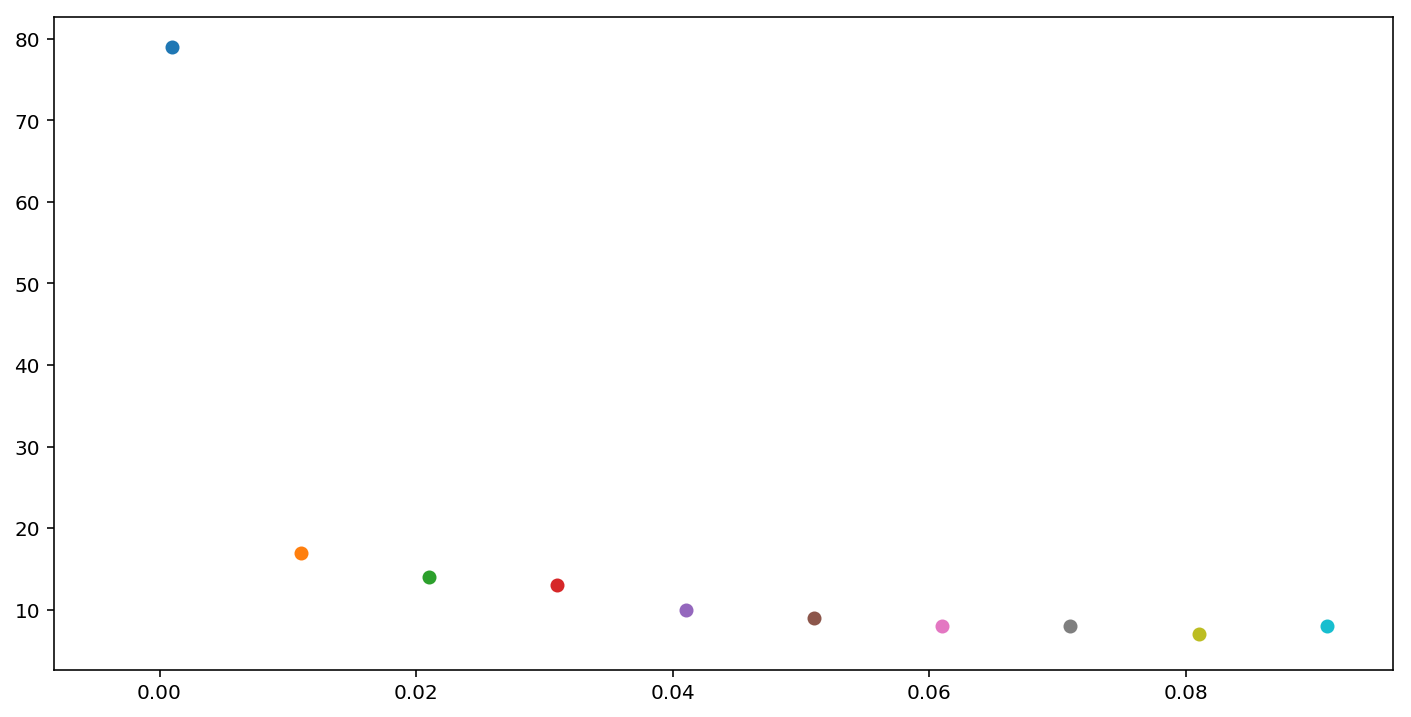

In [22]:
alphas = [i for i in np.arange(0.001,0.1,0.01)]
for alpha in alphas:
    lassoModel = Lasso(alpha=alpha)
    lassoModel.fit(X_train,y)
    coef = pd.Series(lassoModel.coef_, index = X_train.columns)
    x_sum = sum(coef != 0)
    plt.scatter(alpha,x_sum)
    
plt.show()

### 2.5: Ensembling and Stacking with Ridge and Lasso Regression

For ensembling and stacking we have appended the predicted Y values from Lasso and Ridge as two extra columns to our dataset and applied Ridge regression on the whole dataset of features and two y columns. This has given a slightly better R<sup>2</sup> Score.

In [18]:
new_X_train=np.hstack([yrpred.T, ylpred.T])

In [19]:
new_X_train = X_train.copy()

new_X_train['LassoPred']=ylpred
new_X_train['RidgePred']=yrpred

In [46]:
new_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LassoPred,RidgePred
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,1,0,0,0,0,1,0,12.244881,12.239353
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,1,0,0,0,0,1,0,12.160932,12.178790
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,1,0,0,0,0,1,0,12.294685,12.286302
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,1,1,0,0,0,0,0,12.060877,12.032529
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,1,0,0,0,0,1,0,12.616734,12.602386


In [21]:
stack_ridgeModel = Ridge(alpha=.1)
stack_ridgeModel.fit(new_X_train,y)
y_ridgestack_pred=stack_ridgeModel.predict(new_X_train)
y_ridgestack_pred

array([12.24302003, 12.18578078, 12.28674395, ..., 12.55522042,
       11.86530384, 11.85771499])

In [22]:
r2_score_stack_ridge = r2_score(y, y_ridgestack_pred)
print("Ridge - R^2 on test data : %f" % r2_score_stack_ridge)

Ridge - R^2 on test data : 0.947086


### Kaggle Extra Mileage

In [38]:
# Single Lasso Regression
lassoModel = Lasso(alpha=.011)
lassoModel.fit(X_train,y)
pred=lassoModel.predict(X_train)
rmse_lasso = np.sqrt(mean_squared_error(y,pred))
print(rmse_lasso)

# Score for alpha=0.011 Ridge Regression
ridgeModel = Ridge(alpha=.011)
ridgeModel.fit(X_train,y)
pred=ridgeModel.predict(X_train)
rmse_ridge = np.sqrt(mean_squared_error(y,pred))
print(rmse_ridge)


yrpred=ridgeModel.predict(X_train)
r2_score_ridge = r2_score(y, yrpred)
print("Ridge - R^2 on test data : %f" % r2_score_ridge)

ylpred=lassoModel.predict(X_train)
r2_score_lasso = r2_score(y, ylpred)
print("Lasso - R^2 on test data : %f" % r2_score_lasso)

Ridge - R^2 on test data : 0.934678
Lasso - R^2 on test data : 0.930822


In [70]:
new_X_train = X_train.copy()

new_X_train['LassoPred']=ylpred
new_X_train['RidgePred']=yrpred

stack_lassoModel = Lasso(alpha=.0005)
stack_lassoModel.fit(new_X_train,y)
y_lassostack_pred=stack_lassoModel.predict(new_X_train)
y_lassostack_pred

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([12.23612205, 12.18095734, 12.28793219, ..., 12.46105548,
       11.8621975 , 11.85804886])

In [72]:
# Stacking
stack_lassoModel.fit(X_train,y)

ids = test['Id']
yfinalpred = stack_lassoModel.predict(X_test)
sale_prices = np.expm1(yfinalpred)

result = pd.DataFrame({ 'Id': ids, 'SalePrice': np.round(sale_prices, 3) })
display(result.head())

result.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)

coef = pd.Series(stack_lassoModel.coef_, index = X_train.columns)
sum(coef!=0)

110